In [1]:
%load_ext autoreload
%autoreload 2

# General configurations

In [2]:
from layout_prompter.datasets import RicoDataset, PubLayNetDataset

datasets = [RicoDataset(), PubLayNetDataset()] # choices
tasks = ["gen-t", "gen-ts", "gen-r", "completion", "refinement"]

dataset = datasets[0]
task = tasks[0]

input_format = "seq"
output_format = "html"
add_unk_token = False
add_index_token = True
add_sep_token = True
candidate_size = -1  # -1 represents the complete training set
num_prompt = 10

# Process raw data

In [3]:
import os

from layout_prompter.preprocessors import create_processor
from layout_prompter.utils import get_raw_data_path, read_pt, write_pt
from tqdm import tqdm


processor = create_processor(dataset=dataset, task=task)
base_dir = os.path.dirname(os.getcwd())


def get_processed_dataset(split):
    filename = os.path.join(
        base_dir, "dataset", dataset.name, "processed", task, f"{split}.pt"
    )
    if os.path.exists(filename):
        processed_data = read_pt(filename)
    else:
        processed_data = []
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        raw_path = os.path.join(get_raw_data_path(dataset), f"{split}.pt")
        raw_data = read_pt(raw_path)
        for rd in tqdm(raw_data, desc=f"{split} data processing..."):
            processed_data.append(processor(rd))
        write_pt(filename, processed_data)
    return processed_data


processed_train_dataset = get_processed_dataset("train")
processed_val_dataset = get_processed_dataset("val")
processed_test_dataset = get_processed_dataset("test")

# Get target test data

In [4]:
test_idx = 0
test_data = processed_test_dataset[test_idx]

# Define dynamic exemplar selector

In [5]:
from layout_prompter.modules import create_selector


selector = create_selector(
    task=task,
    train_dataset=processed_train_dataset,
    candidate_size=candidate_size,
    num_prompt=num_prompt,
)

# Define input-output serializer

In [6]:
from layout_prompter.modules import create_serializer


serializer = create_serializer(
    dataset=dataset,
    task=task,
    input_format=input_format,
    output_format=output_format,
    add_index_token=add_index_token,
    add_sep_token=add_sep_token,
    add_unk_token=add_unk_token
)

# Define GPT callar

In [7]:
from layout_prompter.parsers import GPTResponseParser
from layout_prompter.modules import GPTCallar

model = "gpt-4"
max_tokens = 800
temperature = 0.7
top_p = 1
frequency_penalty = 0.0
presence_penalty = 0.0
num_return = 10
stop_token = "\n\n"

assert os.environ.get("OPENAI_API_KEY") is not None

parser = GPTResponseParser(
    dataset=dataset, 
    output_format=output_format
)

llm = GPTCallar(
    parser=parser, 
    model=model, 
    max_tokens=max_tokens, 
    temperature=temperature,
    top_p=top_p,
    frequency_penalty=frequency_penalty,
    presence_penalty=presence_penalty,
    num_return=num_return,
    stop_token=stop_token,
)

# Define ranker

In [8]:
from layout_prompter.modules import Ranker


ranker = Ranker(val_dataset=processed_val_dataset)

# Define LayoutPrompter pipeline

In [9]:
from layout_prompter import LayoutPrompter


pipeline = LayoutPrompter(
    serializer=serializer, 
    selector=selector, 
    llm=llm, 
    ranker=ranker,
)

# Generate layouts

In [10]:
exemplars = pipeline.get_exemplars(test_data=test_data)

# (1) Build prompt based on the exemplars
# (2) Generate layouts using LLM
# (3) Re-rank the generated results
ranked_response = pipeline(
    test_data=test_data, exemplars=exemplars
)

# Visualize the layouts

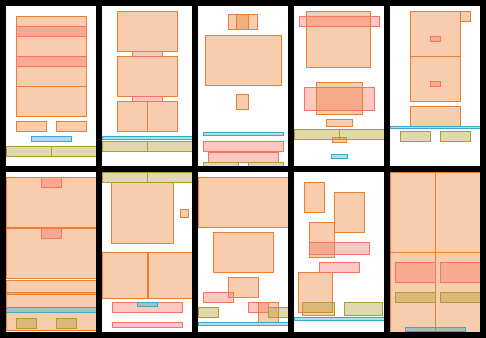

In [11]:
from layout_prompter.visualizers import Visualizer, create_image_grid


visualizer = Visualizer(dataset=dataset)
images = visualizer(ranked_response)

create_image_grid(images)